### Imports & Settings

In [47]:
import torch

from torch import nn, optim

from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import cv2

import copy
import time

In [48]:
torch.manual_seed(123)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(device)

2.2.0+cu121
cuda


### Modules

In [49]:
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)

In [50]:
class FullyConnected(nn.Module):
    '''
    Builds a fully connected neural network from a list of layer sizes and an optional activation function.
    
    Args:
        fc_sizes (list): Sizes of each layer in the network.
        activation (nn.Module): Activation function applied between layers, defaults to SineActivation.
    '''
    def __init__(self, fc_sizes: list, activation=SineActivation):
        super(FullyConnected, self).__init__()
        
        layers = []
        for size_in, size_out in zip(fc_sizes[:-1], fc_sizes[1:-1]):
            layers.append(nn.Linear(size_in, size_out))
            layers.append(activation())
        
        layers.append(nn.Linear(fc_sizes[-2], fc_sizes[-1]))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### Utils

In [51]:
def timer(func):
    '''
    Decorator to measure and print the execution time of the decorated function.

    Args:
        func (callable): Function to measure.

    Returns:
        callable: Wrapped function with timing.
    '''
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f'Executed in {end_time - start_time} seconds.')
        return result
    return wrapper

In [52]:
def get_fourier_embedding(max_freq, num_freqs, log_sampling=True):
    def fourier_embedding(x):
        '''
        Args:
            x (tensor): Input coordinates (N, D), where N is the number of coordinates and D is their dimensionality.
            max_freq (float): The maximum frequency for the Fourier features.
            num_freqs (int): The number of frequencies.
            log_sampling (bool): If true, frequencies are sampled logarithmically. Otherwise, linearly.

        Returns:
            tensor: Fourier embedding of the input coordinates (N, D * num_freqs * 2)
        '''
        if log_sampling:
            freq_bands = 2.0 ** torch.linspace(0.0, max_freq, num_freqs)
        else:
            freq_bands = torch.linspace(2.0 ** 0.0, 2.0 ** max_freq, num_freqs)
        
        embeddings = [x]
        for freq in freq_bands:
            embeddings.append(torch.sin(x * freq))
            embeddings.append(torch.cos(x * freq))
        
        return torch.cat(embeddings, dim=-1)
    return fourier_embedding

In [53]:
def get_normal_field(f):
    def normal_field(x):
        '''
        Compute the normal to the implicit surface represented by a predetermined neural signed distance field.

        Args:
            x (torch.Tensor): A tensor representing a vector in the input space where the normal will be computed.

        Returns:
            torch.Tensor: The normal to the zero-level set of the neural field at point `x`, normalized to unit length.
        '''
        x = x.requires_grad_(True) 

        f_value = f(x)
        grad = torch.autograd.grad(
            outputs=f_value, 
            inputs=x, 
            grad_outputs=torch.ones_like(f_value),
            create_graph=True)[0]
        normal = grad / torch.sqrt(torch.sum(grad ** 2))

        return normal
    return normal_field


In [54]:
def get_uniform_field(f):
    return uniform_field

def uniform_field(x):
    return torch.ones_like(x)

In [55]:
def get_mean_curvature_field(f):
    def mean_curvature_field(x):
        '''
        Compute the mean curvature normal for the implicit surface represented by a neural signed distance field.

        Args:
            x (torch.Tensor): A tensor representing a vector in the input space where the mean curvature normal will be computed.

        Returns:
            torch.Tensor: The mean curvature normal of the zero-level set of the neural field at point `x`.
        '''
        x = x.requires_grad_(True)

        f_value = f(x)
        grad = torch.autograd.grad(
            outputs=f_value,
            inputs=x,
            grad_outputs=torch.ones_like(f_value),
            create_graph=True)[0]

        grad_norm = grad / torch.sqrt(torch.sum(grad ** 2, dim=1, keepdim=True))

        hessian = []
        for i in range(grad.shape[1]):
            hess_grad = torch.autograd.grad(
                outputs=grad[:, i],
                inputs=x,
                grad_outputs=torch.ones_like(grad[:, i]),
                create_graph=True,
                retain_graph=True,
                only_inputs=True)[0]
            hessian.append(hess_grad)
        hessian = torch.stack(hessian, dim=2)

        mean_curvature_normal = torch.bmm(hessian, grad_norm.unsqueeze(2)).squeeze(2)

        return mean_curvature_normal
    return mean_curvature_field


In [56]:
def get_sphere_sdf(r):
    def sphere_sdf(x):
        '''
        Computes the signed distance from the point `x` to a sphere centered at the origin with radius `r`.

        Args:
            x (torch.Tensor): A tensor representing a point in space.

        Returns:
            float: The signed distance from the point `x` to the surface of the sphere.
        '''
        return torch.sum(x ** 2, dim=-1) - r ** 2
    return sphere_sdf

In [57]:
def get_star_sdf(r, n, m):
    def star_sdf(x):      
        an = torch.tensor(torch.pi / n, device=x.device)
        en = torch.tensor(torch.pi / m, device=x.device)
        
        acs = torch.tensor([torch.cos(an), torch.sin(an)], dtype=torch.float32, device=x.device)
        ecs = torch.tensor([torch.cos(en), torch.sin(en)], dtype=torch.float32, device=x.device)
        
        bn = torch.atan2(x[..., 1], x[..., 0]) % (2.0 * an) - an
        x = torch.norm(x, dim=-1, keepdim=True) * torch.cat((torch.cos(bn).unsqueeze(-1), torch.abs(torch.sin(bn)).unsqueeze(-1)), dim=-1)
        
        x = x - r * acs
        dot_product = torch.sum(x * ecs, dim=-1, keepdim=True)
        x = x + ecs * torch.clamp(-dot_product, 0.0, r * acs[1] / ecs[1])
        
        return torch.norm(x, dim=-1) * torch.sign(x[..., 0])
    return star_sdf

In [58]:
def make_annular(sdf_func, r):
    def onion_sdf(pos):
        sdf_values = sdf_func(pos)
        return torch.abs(sdf_values) - r
    return onion_sdf

In [59]:
def create_grid(res=100):
    '''
    Returns a grid of 2D points and the corresponding x, y meshgrid arrays.

    Args:
        res (int): The resolution of the grid, default is 100.

    Returns:
        grid (torch.Tensor): Flattened grid coordinates.
        x (torch.Tensor): X coordinates of the meshgrid.
        y (torch.Tensor): Y coordinates of the meshgrid.
    '''
    p = torch.linspace(-1, 1, res)
    x, y = torch.meshgrid(p, p, indexing='xy')
    grid = torch.stack((x.flatten(), y.flatten()), dim=-1).to(device)
    return grid, x, y

In [60]:
def plot_sdf(net, embedding=None, res=100, contour_lines=15, colormap='RdBu'):
    '''
    Visualizes the SDF generated by a neural network over a fixed range from -1 to 1 for both x and y axes.

    Args:
        net (torch.nn.Module): Neural network model to generate SDF values.
        res (int): Number of points along each axis (res x res grid).
        contour_lines (int): Number of contour lines in the plot.
        colormap (str): Colormap used for visualization.
    '''

    grid, x, y, = create_grid(res)
    if embedding:
        grid = embedding(grid)

    with torch.no_grad():
        z = net(grid).view(res, res).cpu()

    fig, ax = plt.subplots()

    max_abs_value = max(abs(z.min()), abs(z.max()))

    contour_levels = torch.linspace(-max_abs_value, max_abs_value, contour_lines)
    
    c = ax.contourf(
        x.numpy(), y.numpy(), z.numpy(), 
        levels=contour_levels.numpy(), 
        cmap=colormap, 
        origin='lower')
    plt.colorbar(c, ax=ax)
    
    ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
    ax.set_aspect('equal', 'box')
    
    plt.show()

In [61]:
def generate_sdf_video(net, total_time_steps=100, res=200, fps=10):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter('sdf_evolution.mp4', fourcc, fps, (2*res, 2*res))

    grid, x, y = create_grid(res)

    dpi = 100  
    figsize = (2*res / dpi, 2*res / dpi)  

    for t in torch.linspace(0, 1, total_time_steps):
        with torch.no_grad():
            grid_t = torch.cat((grid.cpu(), t.repeat(grid.size(0), 1)), dim=1).to(device)
            z = net(grid_t).view(res, res).cpu()

        fig, ax = plt.subplots(figsize=figsize)
        max_abs_value = max(abs(z.min()), abs(z.max()))
        contour_levels = torch.linspace(-max_abs_value, max_abs_value, 15)

        ax.contourf(x.numpy(), y.numpy(), z.numpy(), levels=contour_levels.numpy(), cmap='RdBu')
        ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
        ax.set_aspect('equal', 'box')
        ax.axis('off')  

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        plt.close(fig)
        out.write(img)

### 1. Training a test SDF

In [62]:
n = 20
grid, _, _ = create_grid(n)

In [63]:
# star params
r = .8
n = 7
m = 4

# annulus
R = 0.1

sdf_values = make_annular(get_star_sdf(r, n, m), R)(grid.cpu())

X = grid
Y = sdf_values.to(device)

# Fourier embedding

max_freq = 32
num_freqs = 16
fe = get_fourier_embedding(max_freq=max_freq, num_freqs=num_freqs)
X = fe(X).to(device)

dataset = TensorDataset(X, Y)

batch_size = 1
dataloader = DataLoader(dataset, batch_size)

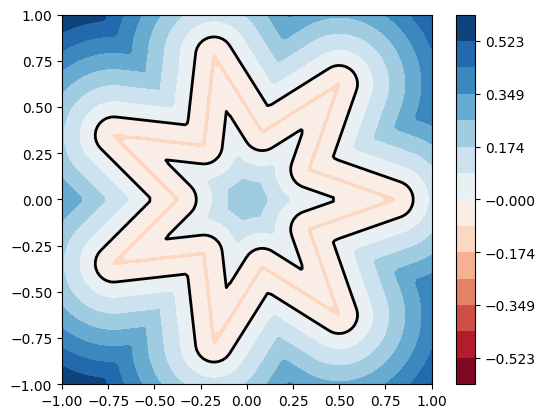

In [64]:
plot_sdf(make_annular(get_star_sdf(r, n, m), R))

In [65]:
n_in = 2 + 2 * 2 * num_freqs
layer_sizes = [n_in, 64, 64, 64, 64, 1]
net = FullyConnected(layer_sizes, activation=torch.nn.ReLU).to(device)

learning_rate = 1e-2
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.01)

In [66]:
num_epochs = 1000
print_every = 25

In [67]:
def get_eikonal_loss(inputs, net):
    inputs.requires_grad_(True)
    outputs = net(inputs)
    grads = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        only_inputs=True)[0]
    gradient_norm = torch.norm(grads, dim=1)
    return ((gradient_norm - 1.0) ** 2).mean()

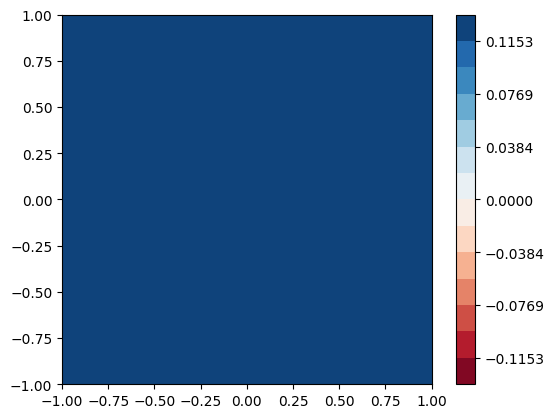

[25/1000] Loss = 0.026620276272296906, LR = 0.001


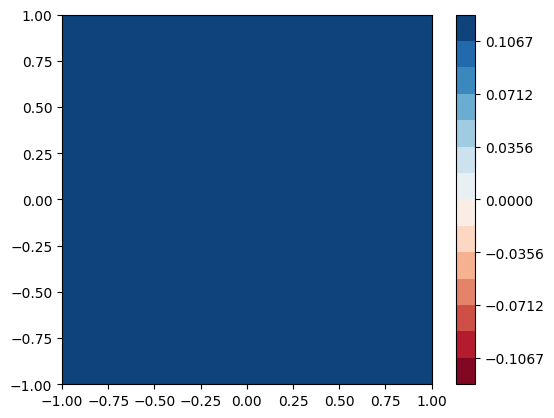

[50/1000] Loss = 0.026530973613262177, LR = 1.0000000000000002e-06


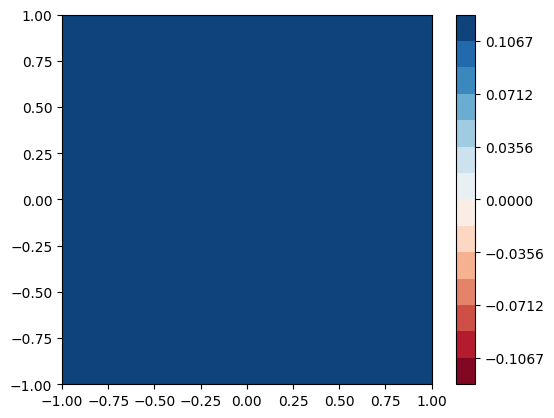

[75/1000] Loss = 0.026530973613262177, LR = 1.0000000000000004e-08


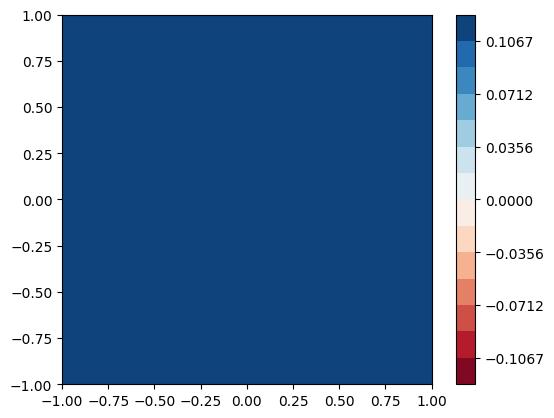

[100/1000] Loss = 0.026530975475907326, LR = 1.0000000000000004e-08


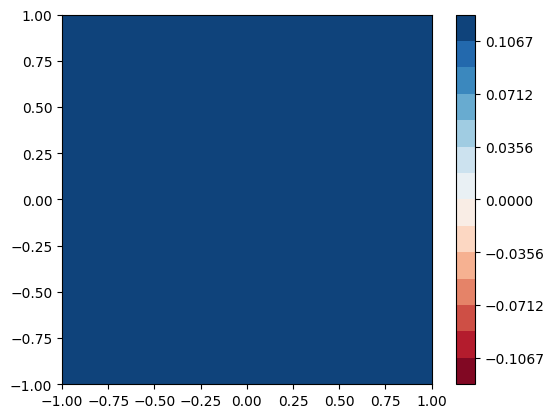

[125/1000] Loss = 0.026530981063842773, LR = 1.0000000000000004e-08


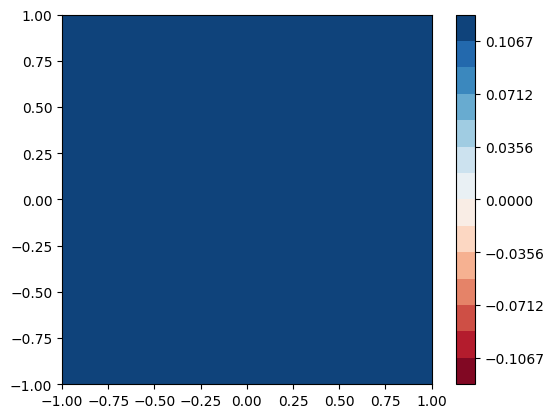

[150/1000] Loss = 0.026530982926487923, LR = 1.0000000000000004e-08


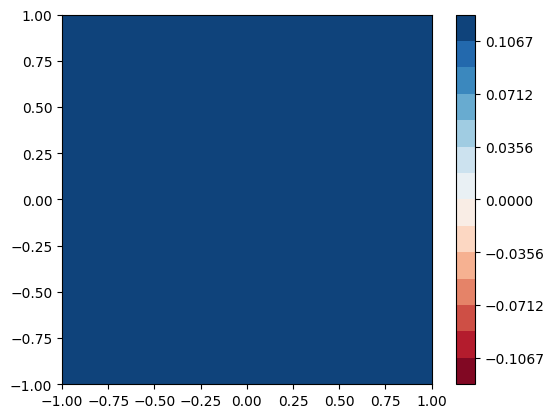

[175/1000] Loss = 0.02653098851442337, LR = 1.0000000000000004e-08


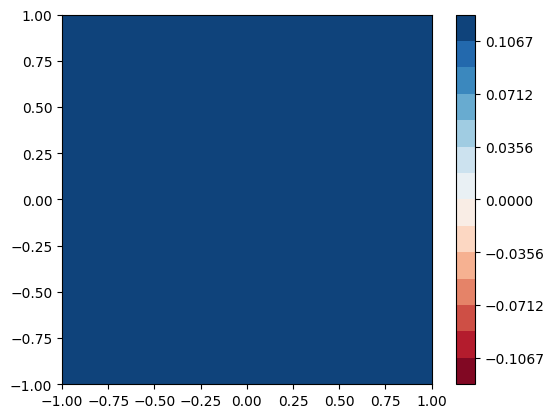

[200/1000] Loss = 0.02653099037706852, LR = 1.0000000000000004e-08


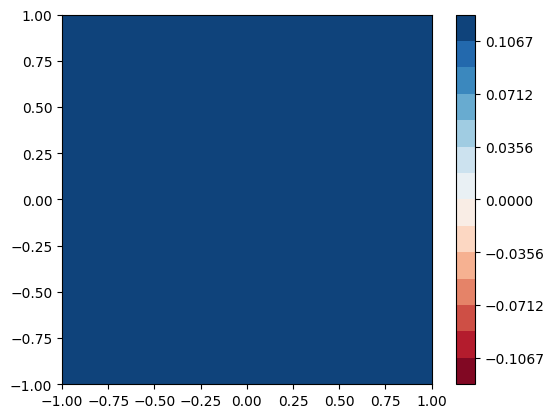

[225/1000] Loss = 0.026530994102358818, LR = 1.0000000000000004e-08


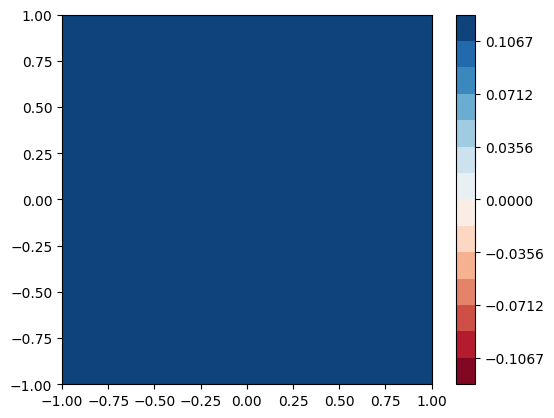

[250/1000] Loss = 0.026530994102358818, LR = 1.0000000000000004e-08


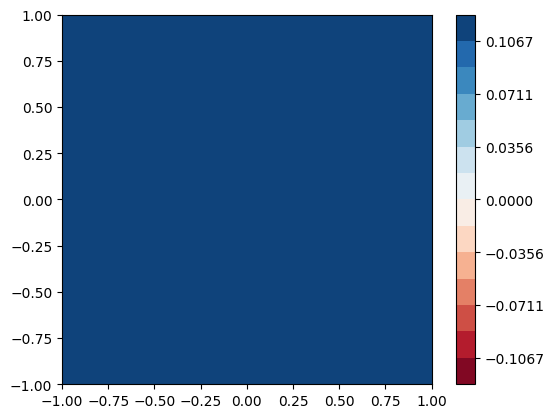

[275/1000] Loss = 0.026531001552939415, LR = 1.0000000000000004e-08


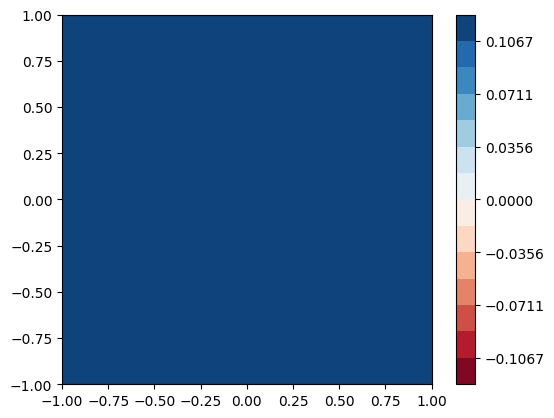

[300/1000] Loss = 0.026531003415584564, LR = 1.0000000000000004e-08


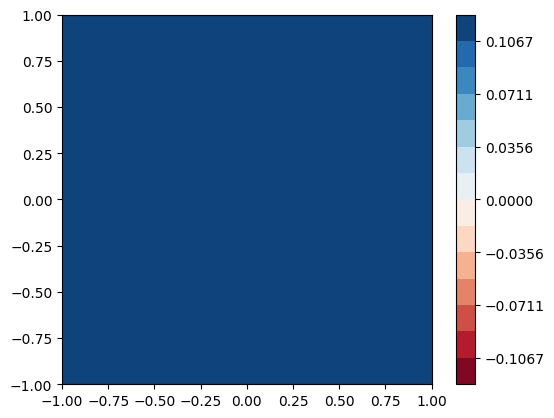

[325/1000] Loss = 0.026531009003520012, LR = 1.0000000000000004e-08


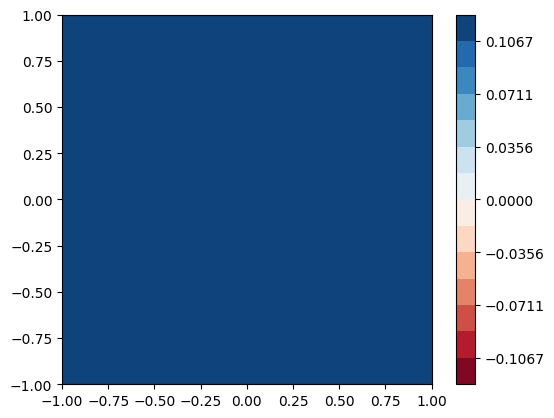

[350/1000] Loss = 0.02653101459145546, LR = 1.0000000000000004e-08


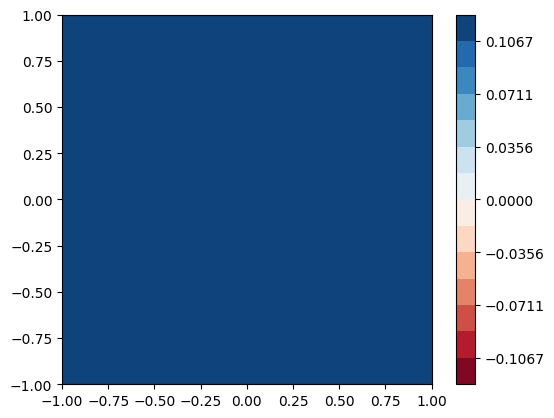

[375/1000] Loss = 0.02653101645410061, LR = 1.0000000000000004e-08


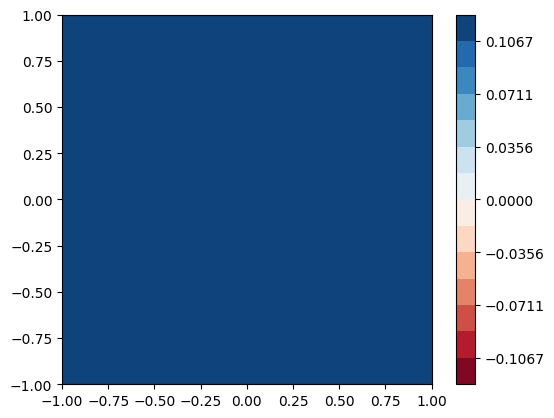

[400/1000] Loss = 0.026531020179390907, LR = 1.0000000000000004e-08


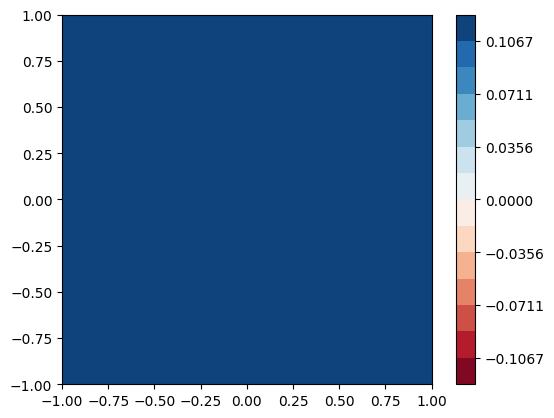

[425/1000] Loss = 0.026531023904681206, LR = 1.0000000000000004e-08


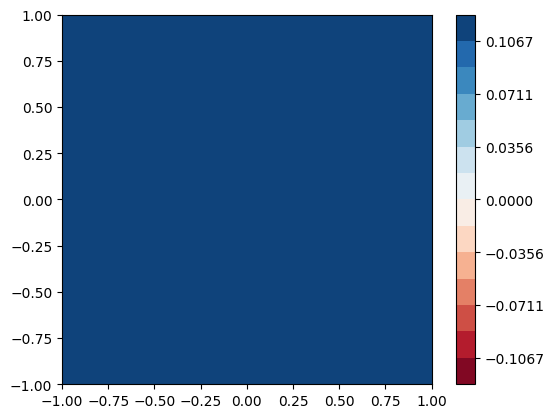

[450/1000] Loss = 0.026531027629971504, LR = 1.0000000000000004e-08


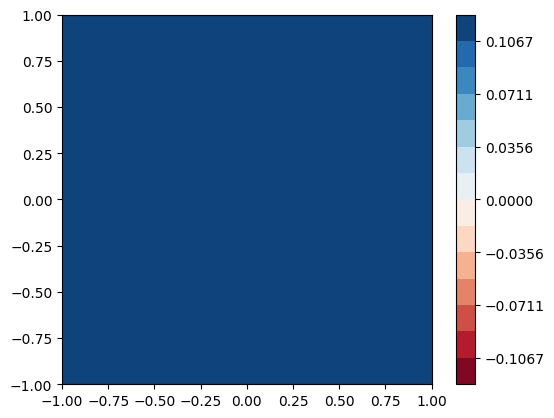

[475/1000] Loss = 0.026531033217906952, LR = 1.0000000000000004e-08


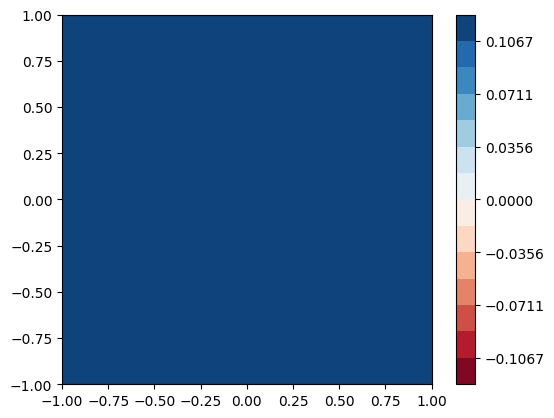

[500/1000] Loss = 0.0265310350805521, LR = 1.0000000000000004e-08


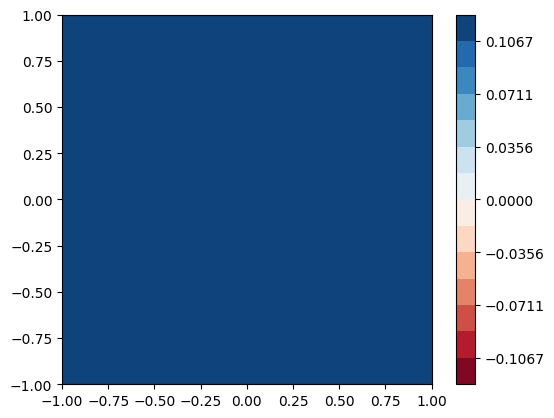

[525/1000] Loss = 0.026531042531132698, LR = 1.0000000000000004e-08


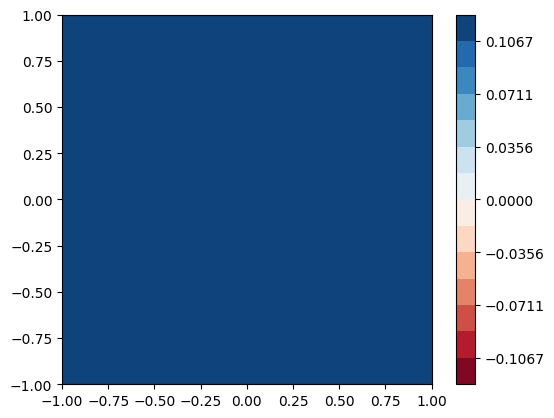

[550/1000] Loss = 0.026531042531132698, LR = 1.0000000000000004e-08


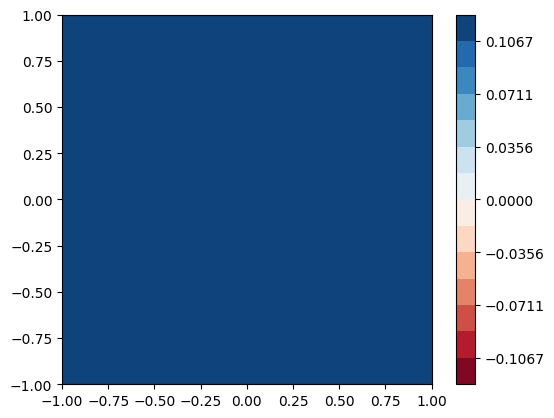

[575/1000] Loss = 0.026531049981713295, LR = 1.0000000000000004e-08


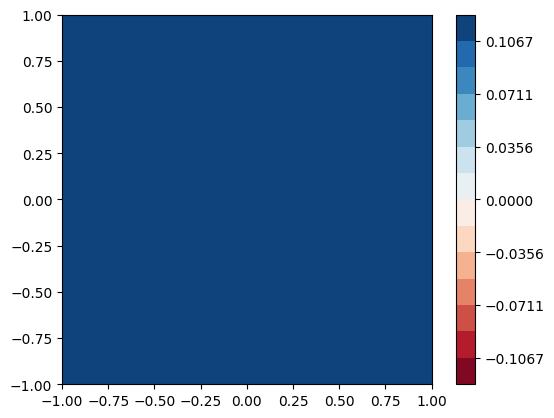

[600/1000] Loss = 0.026531051844358444, LR = 1.0000000000000004e-08


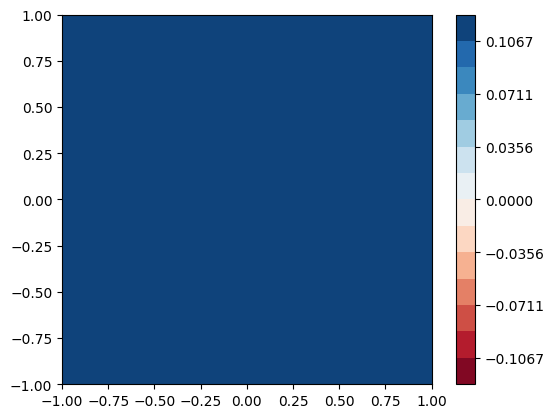

[625/1000] Loss = 0.026531057432293892, LR = 1.0000000000000004e-08


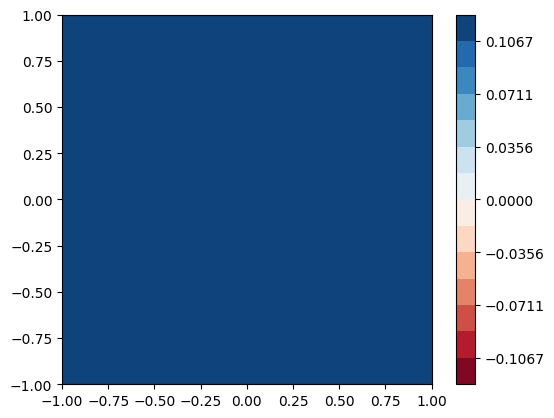

[650/1000] Loss = 0.02653106115758419, LR = 1.0000000000000004e-08


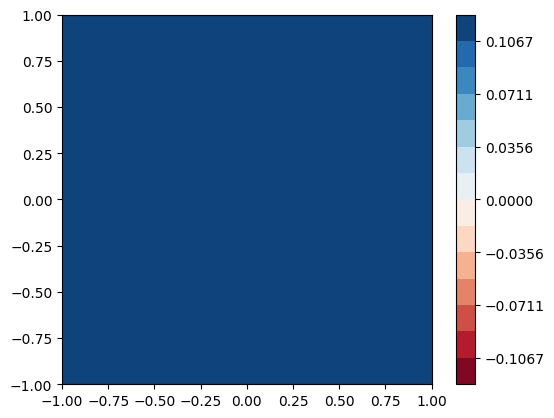

[675/1000] Loss = 0.026531066745519638, LR = 1.0000000000000004e-08


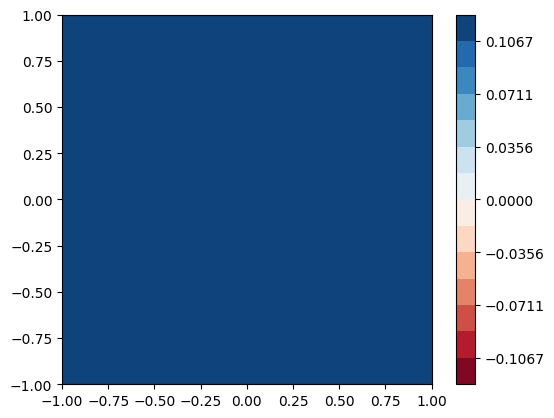

[700/1000] Loss = 0.026531066745519638, LR = 1.0000000000000004e-08


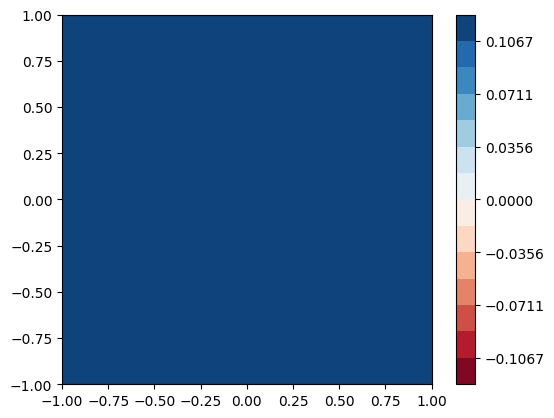

[725/1000] Loss = 0.026531070470809937, LR = 1.0000000000000004e-08


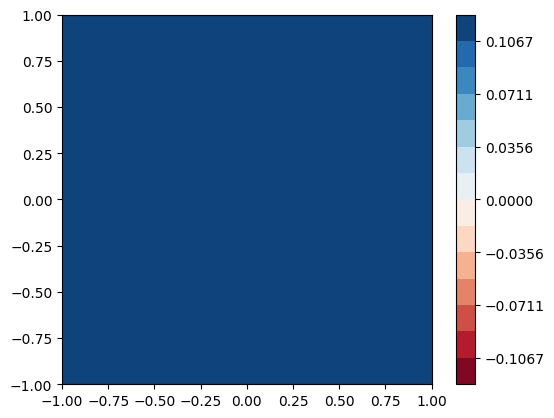

[750/1000] Loss = 0.026531076058745384, LR = 1.0000000000000004e-08


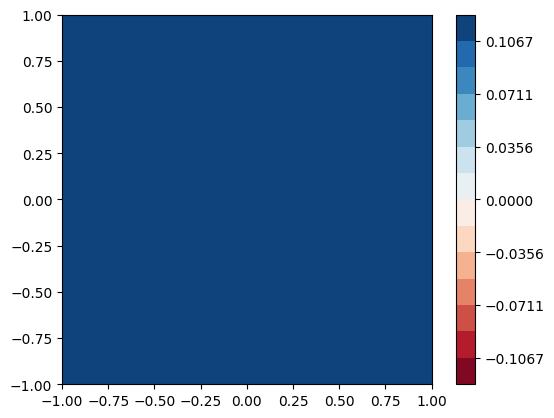

[775/1000] Loss = 0.026531079784035683, LR = 1.0000000000000004e-08


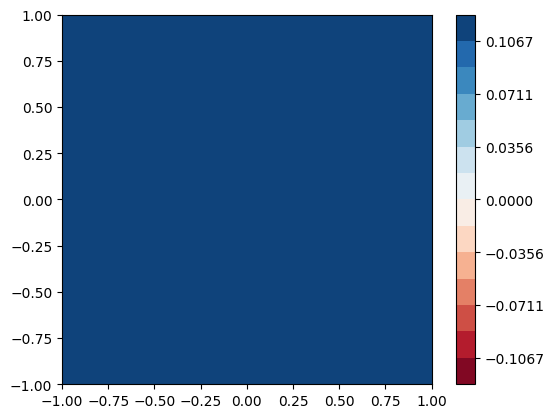

[800/1000] Loss = 0.02653108350932598, LR = 1.0000000000000004e-08


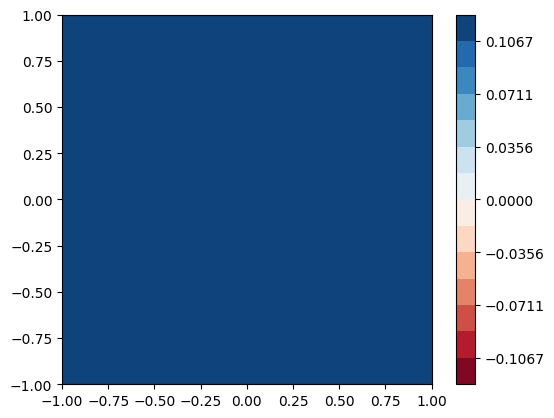

[825/1000] Loss = 0.026531090959906578, LR = 1.0000000000000004e-08


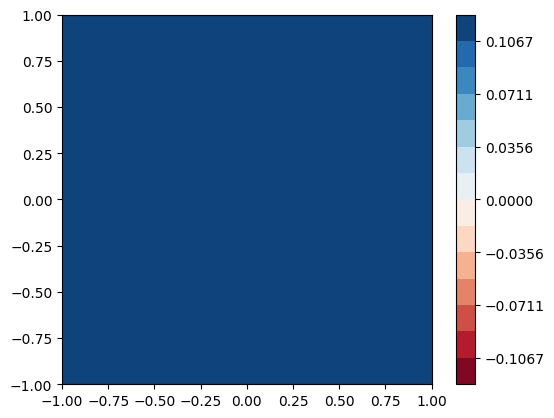

[850/1000] Loss = 0.026531094685196877, LR = 1.0000000000000004e-08


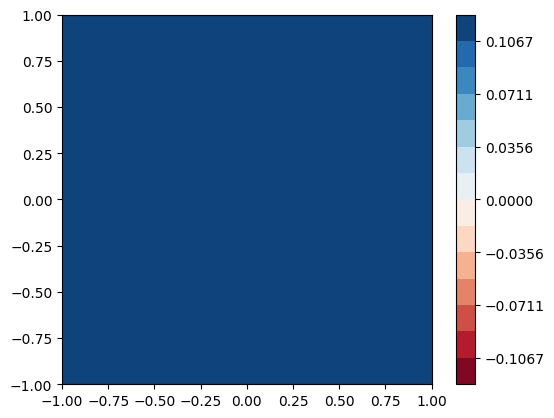

[875/1000] Loss = 0.026531096547842026, LR = 1.0000000000000004e-08


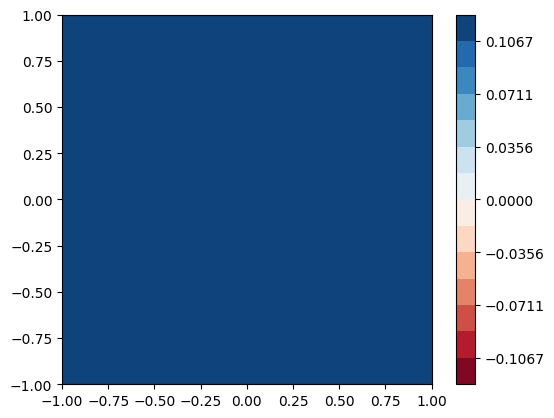

[900/1000] Loss = 0.026531100273132324, LR = 1.0000000000000004e-08


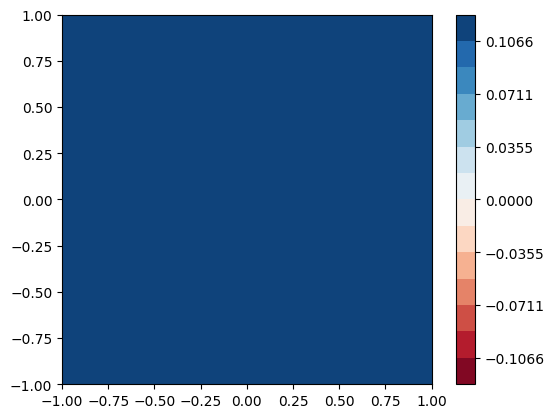

[925/1000] Loss = 0.02653110772371292, LR = 1.0000000000000004e-08


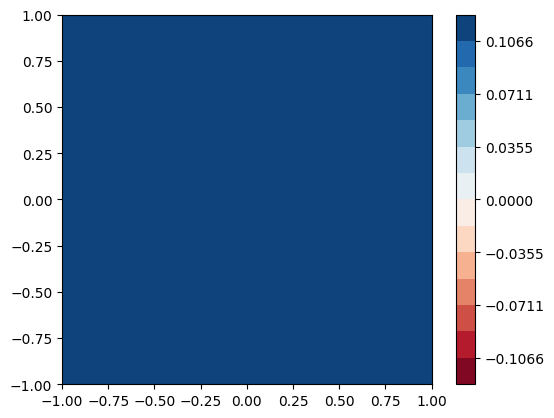

[950/1000] Loss = 0.02653110958635807, LR = 1.0000000000000004e-08


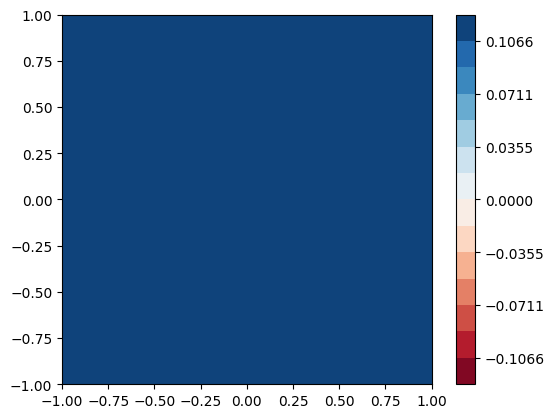

[975/1000] Loss = 0.02653111331164837, LR = 1.0000000000000004e-08


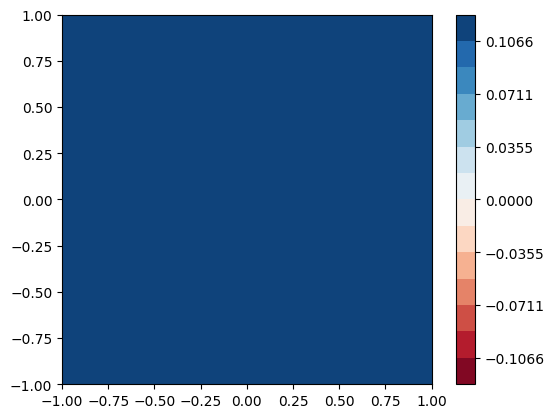

[1000/1000] Loss = 0.026531118899583817, LR = 1.0000000000000004e-08
Executed in 1423.2772426605225 seconds.


In [68]:
@timer
def train_sdf():
    for epoch in range(1, num_epochs+1):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            preds = net(batch_x).flatten()
            mse_loss = nn.MSELoss()(preds, batch_y)
            eikonal_loss = get_eikonal_loss(batch_x, net)
            loss = mse_loss + 0.01 * eikonal_loss
            loss.backward()
            optimizer.step()
        
        # scheduler, evaluation
        net.eval()
        preds = net(X).flatten()
        loss = nn.MSELoss()(preds, Y)
        scheduler.step(loss)

        if epoch % print_every == 0:
            plot_sdf(net, fe)
            current_lr = optimizer.param_groups[0]['lr']
            print(f'[{epoch}/{num_epochs}] Loss = {loss.item()}, LR = {current_lr}')
            
        net.train()

train_sdf()

In [69]:
plot_sdf(net)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x2 and 66x64)

### 2. Solving the initial value problem

In [ ]:
def get_pde_loss(net, V, input: dict, speed=1):
    phi_xt = net(input['xyt'])

    grad_phi = torch.autograd.grad(
        outputs=phi_xt,
        inputs= input['xyt'],
        grad_outputs=torch.ones_like(phi_xt),
        create_graph=True,
        only_inputs=True
    )[0]

    dx_phi = grad_phi[:, 0:-1]
    dt_phi = grad_phi[:, -1]

    Vx = V(input['xy'])
    n = input['xyt'].size(0) // input['xy'].size(0) # n = number of time steps

    prod = torch.einsum('ij, ij -> i', speed * Vx.repeat(n, 1), dx_phi).view(-1,1)

    return ((dt_phi + prod) ** 2).mean()

In [ ]:
def get_ic_loss(pinn, f, input: dict):
    return ((pinn(input['xyt0']) - f(input['xy'])) ** 2).mean()

In [ ]:
layer_sizes = [3, 1024, 1024, 1024, 1024, 512, 512, 256, 128, 1]
pinn = FullyConnected(layer_sizes).to(device)

In [ ]:
learning_rate = 1e-3
optimizer = optim.Adam(pinn.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [ ]:
n = 25
x0, x1, y0, y1 = -1, 1, -1, 1
t0, t1 = 0, 1

x = torch.linspace(x0, x1, n)
y = torch.linspace(y0, y1, n)
t = torch.linspace(t0, t1, n)

X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
XT = torch.stack((X.flatten(), Y.flatten(), T.flatten()), dim=1).requires_grad_(True).to(device)

_X, _Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack((_X.flatten(), _Y.flatten()), dim=1).to(device).requires_grad_(True)

T0 = torch.zeros_like(_X) 
XT0 = torch.stack((_X.flatten(), _Y.flatten(), T0.flatten()), dim=1).requires_grad_(True).to(device)

input_pde = dict(xyt=XT, xy=grid)
input_ic = dict(xyt0=XT0, xy=grid)

In [ ]:
pde_dataset = TensorDataset(input_pde['xyt'], input_pde['xy'])
ic_dataset = TensorDataset(input_ic['xyt0'], input_ic['xy'])

batch_size_pde = 32
batch_size_ic = 32

pde_loader = DataLoader(pde_dataset, batch_size=batch_size_pde, shuffle=True)
ic_loader = DataLoader(ic_dataset, batch_size=batch_size_ic, shuffle=True)

In [ ]:
num_epochs = 5000
print_every = 5

In [ ]:
@timer
def run_pinn_training(speed=10):
    for epoch in range(1, num_epochs+1):
        pde_iter = iter(pde_loader)
        ic_iter = iter(ic_loader)

        while True:
            try:
                xyt_pde, xy_pde = next(pde_iter)
                xyt_ic, xy_ic = next(ic_iter)
            except StopIteration:
                break

            optimizer.zero_grad()

            input_pde_batch = {'xyt': xyt_pde.to(device), 'xy': xy_pde.to(device)}
            input_ic_batch = {'xyt0': xyt_ic.to(device), 'xy': xy_ic.to(device)}

            #pde_loss = get_pde_loss(pinn, get_normal_field(net), input_pde_batch, speed=speed)
            pde_loss = get_pde_loss(pinn, get_uniform_field(net), input_pde_batch, speed=speed)
            #pde_loss = get_pde_loss(pinn, get_mean_curvature_field(net), input_pde_batch, speed=speed)

            ic_loss = get_ic_loss(pinn, net, input_ic_batch)
            loss = 0.01 * pde_loss + 1 * ic_loss
            loss.backward()
            optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item()}')

run_pinn_training()

Epoch [5/5000] Loss = 5348.10888671875


Epoch [10/5000] Loss = 338.60614013671875
Epoch [15/5000] Loss = 147.7559051513672
Epoch [20/5000] Loss = 109.1698989868164
Epoch [25/5000] Loss = 53.686038970947266
Epoch [30/5000] Loss = 38.89451217651367
Epoch [35/5000] Loss = 7.604963779449463
Epoch [40/5000] Loss = 2.1182613372802734
Epoch [45/5000] Loss = 0.6045495271682739
Epoch [50/5000] Loss = 0.8707702159881592
Epoch [55/5000] Loss = 0.7226723432540894
Epoch [60/5000] Loss = 0.5197166800498962
Epoch [65/5000] Loss = 0.3754061162471771
Epoch [70/5000] Loss = 0.29763174057006836
Epoch [75/5000] Loss = 0.2695128917694092
Epoch [80/5000] Loss = 0.2515696883201599
Epoch [85/5000] Loss = 0.2416989952325821
Epoch [90/5000] Loss = 0.2307778298854828
Epoch [95/5000] Loss = 0.22154250741004944
Epoch [100/5000] Loss = 0.21201303601264954
Epoch [105/5000] Loss = 0.20363901555538177
Epoch [110/5000] Loss = 0.19569551944732666
Epoch [115/5000] Loss = 0.18853062391281128
Epoch [120/5000] Loss = 0.1817476600408554
Epoch [125/5000] Loss = 0.1

In [ ]:
generate_sdf_video(pinn)